Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Lab 1 - Simulated Annealing for the Multi-dimensional Knapsack Problem

This implementation addresses the multi-dimensional, multi-knapsack optimization problem, an extension of the classic 0-1 Knapsack Problem in which multiple knapsacks must be filled with items characterized by both a value and a multi-dimensional weight vector.
Each knapsack has capacity constraints across several dimensions (e.g., weight, volume, or cost), and the objective is to maximize the total value of all items placed without exceeding any constraint in any knapsack.

Given the combinatorial nature and computational complexity of this problem (NP-hard), the algorithm employs a Simulated Annealing (SA) metaheuristic to search for near-optimal solutions within a reasonable time.

### Overview of the Simulated Annealing Method

Simulated Annealing is a probabilistic optimization algorithm inspired by the physical process of annealing in metallurgy, where a material is heated and gradually cooled to reach a state of minimal energy.

In the context of optimization, the algorithm explores the search space by iteratively modifying a candidate solution.
It accepts not only improving moves but occasionally also worse moves, with a probability that decreases as the system "cools".
This allows it to escape local optima and converge toward a global or near-global optimum.
At each iteration, the algorithm:
1. Generates a neighboring solution ( tweak() function);
2. Evaluates its quality (total value);
3. Decides whether to accept it based on the Metropolis acceptance criterion:

\begin{equation*}
P(\text { accept })= \begin{cases}1, & \text { if } \Delta>0 \\ e^{\Delta / T}, & \text { if } \Delta \leq 0\end{cases}
\end{equation*}

where $\Delta$ is the change in objective value and $T$ is the current temperature.
The temperature decreases according to an exponential cooling schedule:

\begin{equation*}
T_i=T_0\left(\frac{T_f}{T_0}\right)^{i / N}
\end{equation*}

where $T_0$ and $T_f$ are the initial and final temperatures, respectively, and $N$ is the total number of iterations.

### Neighborhood Generation: The `tweak()` Function

The `tweak()` function determines how new candidate solutions are generated based on the current temperature:
- High Temperature (Exploration Phase):
  - The algorithm performs random modifications using the `random_edit` function.
  - Random edits include adding, removing, or transferring items between knapsacks.
- Low Temperature (Exploitation Phase):
  - The algorithm applies value-based improvements using the `value_based_edit` function.
  - This function attempts to insert high-value, space-efficient items (based on value-to-weight ratio) into available knapsacks.
  - If all items are already assigned, it calls `optimize_transfers()` to locally refine the current configuration.

If a valid solution (i.e., one that respects all capacity constraints) is found, it is returned immediately. Otherwise, the process repeats for a limited number of attempts before reverting to the previous state.

### Local Editing Operators
1. `random_edit()`
  Performs a single stochastic operation:
  - Add: Randomly adds an unassigned item to a feasible knapsack.
  - Remove: Randomly removes an item from a knapsack.
  - Transfer: Moves an item from one knapsack to another if it fits.

This operator introduces controlled randomness, allowing the algorithm to explore different configurations without deterministic bias.

2. `value_based_edit()`

  Attempts to greedily improve the current solution:
  - Computes the value density of unassigned items as:

  \begin{equation*}
  \operatorname{density}(i)=\frac{\operatorname{value}(i)}{\|\operatorname{weight}(i)\|_2+\epsilon}
  \end{equation*}

  - Sorts items by decreasing density and assigns them to the knapsack that provides the best utilization of remaining space.
  - If all items are already assigned, it calls `optimize_transfers()`.
3. `optimize_transfers()`

  Performs local optimization by considering item transfers between knapsacks.
  It moves an item only if doing so enables the inclusion of a more valuable unassigned item elsewhere, thereby increasing the total system value.

  This process iterates until no further improvements can be made or a maximum number of passes is reached.

### Acceptance and Cooling Schedule

At each iteration:
1. The new solution is compared with the current one.
2. If it improves the objective value, it is always accepted.
3. Otherwise, it is accepted with a temperature-dependent probability.

As the temperature decreases, the algorithm transitions from a global exploratory search to a local finetuning phase.
This gradual cooling allows convergence to a stable, high-quality solution.

If the algorithm fails to improve for a specified number of iterations ( `early_stop` ), it terminates early to reduce computation time.
Additionally, if stagnation is detected before reaching the early stop threshold, the algorithm restarts from the best-known solution to resume progress.

In [1]:
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import math
from matplotlib import pyplot as plt

In [ ]:
class KnapsackOptimizer:
    def __init__(self, params):
        """Initialize with parameters from dictionary."""
        self.constraints = params['constraints']
        self.weights = params['weights']
        self.values = params['values']
        self.num_knapsacks = params['num_knapsacks']
        self.num_items = params['num_items']

        self.iterations = params.get('iterations', 10000)
        self.initial_temp = params.get('initial_temperature', 10 * math.log10(self.num_items * self.weights.shape[1]))
        self.final_temp = params.get('final_temperature', self.initial_temp * 0.01)
        self.early_stop = params.get('early_stop', self.iterations // 5)

        self.best_values = []
        self.best_solution = None
        self.best_value = 0
    
    def __str__(self):
        """Return a human-readable string representation of the optimizer."""
        s = f"KnapsackOptimizer:\n"
        s += f"  Problem size: {self.num_items} items, {self.num_knapsacks} knapsacks, {self.weights.shape[1]} dimensions\n"
        s += f"  Temperature: {self.initial_temp:.2f} → {self.final_temp:.2f}\n"
        s += f"  Iterations: {self.iterations} (early stop after {self.early_stop} non-improving iterations)\n"
        
        if hasattr(self, 'best_value') and self.best_value > 0:
            s += f"  Optimization status: Complete\n"
            s += f"  Best value: {self.best_value}\n"
            if hasattr(self, 'best_values') and self.best_values:
                s += f"  Progress: {self.best_values[0]} → {self.best_values[-1]}\n"
                improvement = (self.best_values[-1] / self.best_values[0] - 1) * 100
                s += f"  Improvement: {improvement:.1f}%\n"
        else:
            s += f"  Optimization status: Not started\n"
        
        return s

    def __repr__(self):
        """Return a string representation of the optimizer."""
        return f"KnapsackOptimizer(items={self.num_items}, knapsacks={self.num_knapsacks}, dims={self.weights.shape[1]})"

    """ HELPER METHODS """
    def space_left(self, knapsack):
        """Calculate remaining space in a knapsack."""
        if not knapsack.any():
            return self.constraints.copy()
        return self.constraints - self.weights[knapsack].sum(axis=0)

    def is_valid(self, knapsacks):
        """Check if all knapsacks are within constraints."""
        for k in range(self.num_knapsacks):
            selected_items = np.where(knapsacks[k])[0]
            if len(selected_items) > 0:
                knapsack_weights = self.weights[selected_items].sum(axis=0)
                if np.any(knapsack_weights > self.constraints):
                    return False
        return True

    def value(self, knapsacks):
        """Calculate total value of items in all knapsacks."""
        total_value = 0
        for k in range(self.num_knapsacks):
            selected_items = np.where(knapsacks[k])[0]
            total_value += self.values[selected_items].sum()
        return total_value

    def random_valid_solution(self):
        """Generate a random valid solution."""
        knapsacks = np.zeros((self.num_knapsacks, self.num_items), dtype=bool)

        while True:
            for item in range(self.num_items):
                k = np.random.randint(self.num_knapsacks)
                if np.all(self.space_left(knapsacks[k]) >= self.weights[item]):
                    knapsacks[k][item] = True
            if self.is_valid(knapsacks):
                break
        return knapsacks
    
    def plot_optimization(self):
        """Plot the progress of the optimization."""
        plt.plot(range(len(self.best_values)), self.best_values, label='Best Value')
        plt.xlabel('Iterations')
        plt.ylabel('Value')
        plt.title('Knapsack Optimization Progress')
        plt.legend()

    """ OPTIMIZATION METHODS """
    def random_edit(self, knapsacks):
        """Randomly add, remove, or transfer an item."""
        knapsacks = knapsacks.copy()
        operation = np.random.choice(['add', 'remove', 'transfer'])
        
        if operation == 'add':
            all_items = np.any(knapsacks, axis=0)
            available_items = np.where(~all_items)[0]
            if len(available_items) > 0:
                item = np.random.choice(available_items)
                k = np.random.randint(self.num_knapsacks)
                if np.all(self.space_left(knapsacks[k]) >= self.weights[item]):
                    knapsacks[k][item] = True
        elif operation == 'remove':
            for k in range(self.num_knapsacks):
                items_in_k = np.where(knapsacks[k])[0]
                if len(items_in_k) > 0:
                    item = np.random.choice(items_in_k)
                    knapsacks[k][item] = False
                    break
        else:
            k1, k2 = np.random.choice(self.num_knapsacks, size=2, replace=False)
            items_in_k1 = np.where(knapsacks[k1])[0]
            if len(items_in_k1) > 0:
                item = np.random.choice(items_in_k1)
                if np.all(self.space_left(knapsacks[k2]) >= self.weights[item]):
                    knapsacks[k1][item] = False
                    knapsacks[k2][item] = True
        return knapsacks

    def value_based_edit(self, knapsacks):
        """Simple value-based editing using current knapsack state."""
        knapsacks = knapsacks.copy()
        
        # Get items not currently in any knapsack
        unassigned_items = [item for item in range(self.num_items) if not np.any(knapsacks[:, item])]
        
        if not unassigned_items:
            # If all items are assigned, try to optimize transfers
            return self.optimize_transfers(knapsacks)
        
        # Sort unassigned items by value density
        items_with_density = []
        for item in unassigned_items:
            # Use Euclidean norm for multi-dimensional weight
            weight_norm = np.linalg.norm(self.weights[item])
            value_density = self.values[item] / (weight_norm + 1e-9)
            items_with_density.append((item, value_density))
        
        items_with_density.sort(key=lambda x: x[1], reverse=True)
        
        # Try to add high-value items to knapsacks where they fit best
        for item, _ in items_with_density:
            best_k = -1
            best_fit = -1
            
            for k in range(self.num_knapsacks):
                space_left = self.space_left(knapsacks[k])
                
                if np.all(space_left >= self.weights[item]):
                    # Calculate how well this item fits
                    fit_score = 0
                    for d in range(len(self.constraints)):
                        if space_left[d] > 0:
                            utilization = self.weights[item][d] / space_left[d]
                            fit_score += utilization
                    
                    if fit_score > best_fit:
                        best_k = k
                        best_fit = fit_score
            
            if best_k != -1:
                knapsacks[best_k][item] = True
        
        return knapsacks

    def optimize_transfers(self, knapsacks):
        """Optimize by transferring items between knapsacks."""
        knapsacks = knapsacks.copy()
        
        # Try to improve by transferring items
        improved = True
        max_passes = 10
        passes = 0
        
        while improved and passes < max_passes:
            improved = False
            passes += 1
            
            for item in range(self.num_items):
                current_k = np.where(knapsacks[:, item])[0][0]
                
                # Check if moving to another knapsack would be better
                for k in range(self.num_knapsacks):
                    if k == current_k:
                        continue
                    
                    # Check if item fits in target knapsack
                    if np.all(self.space_left(knapsacks[k]) >= self.weights[item]):
                        # Check if this move would allow adding more valuable items
                        current_space_after_remove = self.space_left(knapsacks[current_k]) + self.weights[item]
                        target_space_after_add = self.space_left(knapsacks[k]) - self.weights[item]
                        
                        # Find best item that could be added to current knapsack after removal
                        best_additional_value = 0
                        for other_item in range(self.num_items):
                            if not np.any(knapsacks[:, other_item]) and np.all(current_space_after_remove >= self.weights[other_item]):
                                if self.values[other_item] > best_additional_value:
                                    best_additional_value = self.values[other_item]
                        
                        # If we can get more value by moving, do it
                        if best_additional_value > self.values[item]:
                            knapsacks[current_k][item] = False
                            knapsacks[k][item] = True
                            improved = True
                            break
        
        return knapsacks

    def tweak(self, knapsacks, temperature):
        """Tweak solution based on temperature."""
        knapsacks = knapsacks.copy()
        max_attempts = 20
        attempt = 0
        
        while attempt < max_attempts:
            # More exploration at high temperatures, more exploitation at low temperatures
            if np.random.rand() < temperature:
                # At high temperatures, make more random changes
                num_edits = max(1, int(3 * temperature))
                temp_solution = knapsacks.copy()
                for _ in range(num_edits):
                    temp_solution = self.random_edit(temp_solution)
                knapsacks = temp_solution
            else:
                # At low temperatures, focus on value-based improvements
                knapsacks = self.value_based_edit(knapsacks)
                
            if self.is_valid(knapsacks):
                return knapsacks
            
            attempt += 1
        
        # If we can't find a valid solution after max attempts, return original
        return knapsacks.copy()

    def optimize(self):
        """Perform simulated annealing to optimize knapsack solution."""
        solution = self.random_valid_solution()
        actual_value = self.value(solution)
        best_solution = deepcopy(solution)
        best_value = actual_value

        self.best_values = []
        no_improvement_count = 0
        
        pbar = tqdm(range(self.iterations), desc="Optimizing")
        for i in pbar:
            temperature = self.initial_temp * math.pow(self.final_temp / self.initial_temp, i / self.iterations)
            new_solution = self.tweak(solution, temperature=temperature)
            new_value = self.value(new_solution)

            # Calculate acceptance probability
            delta = new_value - actual_value
            acceptance_probability = 1.0 if delta > 0 else math.exp(delta / temperature)
            
            if np.random.random() < acceptance_probability:
                solution = new_solution
                actual_value = new_value
                if actual_value > best_value:
                    best_solution = deepcopy(solution)
                    best_value = actual_value
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1
            else:
                no_improvement_count += 1

            # Early stopping check
            if no_improvement_count >= self.early_stop:
                pbar.set_postfix({'value': best_value, 'temp': temperature, 'status': 'early stopped'}, refresh=True)
                tqdm.write("Early stopping.")
                pbar.close()
                break
                
            # Restart from best solution if stuck for a while but not enough to stop
            if no_improvement_count > 1000 and no_improvement_count < self.early_stop:
                solution = deepcopy(best_solution)
                actual_value = best_value
                no_improvement_count = 0

            self.best_values.append(best_value)
            pbar.set_postfix({'value': best_value, 'temp': temperature}, refresh=True)
        
        self.best_solution = best_solution
        self.best_value = best_value

## TEST PROBLEMS

In [ ]:
# Problem 1:
rng = np.random.default_rng(seed=42)

params = {
    'num_items': 20,
    'num_dimensions': 2,
    'num_knapsacks': 3,
    'values': rng.integers(0, 100, size=20),
    'weights': rng.integers(0, 100, size=(20, 2)),
    'constraints': rng.integers(0, 100 * 20 // 3, size=2),
    'iterations': 10000,
    'initial_temperature': 100.0,
    'final_temperature': 0.01,
}

ko1 = KnapsackOptimizer(params)
ko1.optimize()

Optimizing:   6%|▋         | 626/10000 [00:12<03:11, 49.05it/s, value=1065, temp=56.2]


KeyboardInterrupt: 

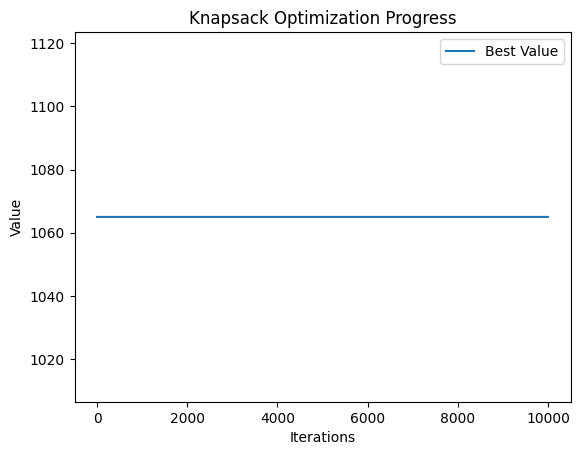

In [ ]:
ko1.plot_optimization()

In [ ]:
# Problem 2:
rng = np.random.default_rng(seed=42)

params = {
    'num_items': 100,
    'num_dimensions': 10,
    'num_knapsacks': 10,
    'values': rng.integers(0, 1000, size=100),
    'weights': rng.integers(0, 1000, size=(100, 10)),
    'constraints': rng.integers(1000 * 2, 1000 * 100 // 10, size=10),
    'iterations': 10000,
    'initial_temperature': 100.0
}

ko2 = KnapsackOptimizer(params)
best_solution, best_value, best_values = ko2.optimize()

Optimizing: 100%|██████████| 10000/10000 [01:33<00:00, 107.47it/s, value=34006, temp=1]  


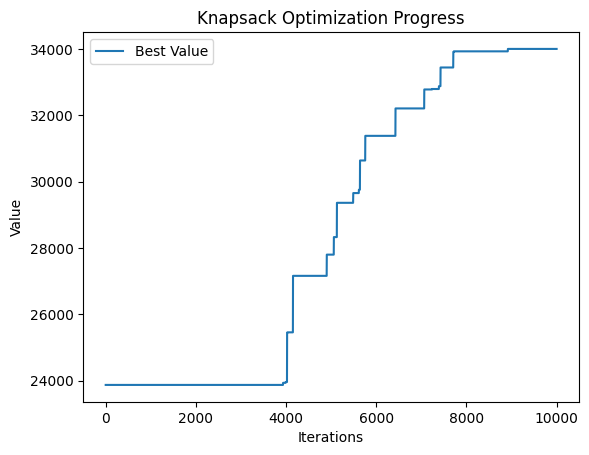

In [4]:
plt.plot(range(len(best_values)), best_values, label='Best Value')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Knapsack Optimization Progress')
plt.legend()

In [7]:
# Problem 3:
rng = np.random.default_rng(seed=42)

params = {
    'num_items': 5000,
    'num_dimensions': 100,
    'num_knapsacks': 100,
    'values': rng.integers(0, 1000, size=5000),
    'weights': rng.integers(0, 1000, size=(5000, 100)),
    'constraints': rng.integers(1000 * 10, 1000 * 2 * 5000 // 100, size=100),
    'iterations': 5000,
    'initial_temperature': 400.0
}

ko3 = KnapsackOptimizer(params)
best_solution, best_value = ko3.optimize()

Optimizing:  20%|█▉        | 998/5000 [02:03<08:17,  8.05it/s, value=1152312, temp=159, status=early stopped]

Early stopping.


ValueError: too many values to unpack (expected 2)